## Cosmological Parameter Estimation With Graph Neural Nets
$\sigma_8$ is a variance of linear matter overdensity at the scale of 8 Mpc. It's an important cosmological parameter that defines how strongly matter clumps at this scale.

$\sigma_W = \langle (\delta_W(\mathbf{x})^2) \rangle$ Where $\delta(\mathbf{x})$ is matter overdensity and W is a top-hat filter, in real space $W_{R} = \frac{4\pi R^3}{3}\Theta(r)\Theta(R-r)$, $\Theta(x)$ - Heaviside step function. Then
$\sigma_W = \int \frac{d^3k}{(2\pi)^3}P_L(k)|W_R(k)|$ where $W_R(k)$ is a fourier transform of the given filter and $P_L$ is a linear matter power spectrum.

In this notebook, we will try to learn to predict this parameter with halo catalogs (almost galaxies) from CAMELS DM simulations with Graph Neural Nets.
Let's have a look on the data

In [1]:
import os
#!pip uninstall -y numpy
#!pip install numpy==1.26.0
#!pip uninstall -y torch torchvision torchaudio
#!pip install torch==2.1.0+cu121 torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
import torch
#os.environ['TORCH'] = torch.__version__
#print(torch.__version__)
#!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
#!pip install -q pytorch-lightning

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')
#path = '/content/drive/Othercomputers/My PC/Spring2024/Physics361/Problem_Sets/04_Problem_Set'
path = os.getcwd()
#data = np.load(path+'/halos.npz')

In [4]:
data = np.load('halos.npz')
## These are halo catalogs from CAMELS n-body cosmological simulations. Each entry contain a list of dark matter halos with their propertiec in the volume of (25Mpc/h)^3.
print(data.keys(),f'Length: {data.keys().__len__()}')

KeysView(NpzFile 'halos.npz' with keys: sim_0, sim_1, sim_2, sim_3, sim_4...) Length: 1351


In [5]:
data['sim_0'][:5]
# each array is of size 4xN, where N is a number of dark matter halos in (25 MPc)^3 volume.
#The first three columns are position vector, the last one is mass in units of 1e10xM_sun (yes, DM halos are heavy!)
#Let's have a closer look:

array([[6.5749711e-01, 5.0597584e-01, 1.3640997e-01, 7.4416167e+03],
       [6.8168944e-01, 4.9442321e-01, 1.2664360e-01, 1.1832811e+03],
       [6.7056596e-01, 5.0952804e-01, 1.2727998e-01, 7.6187302e+01],
       [6.8308491e-01, 4.9033743e-01, 1.2856142e-01, 7.1069565e+01],
       [6.5589452e-01, 5.0702369e-01, 1.4110702e-01, 5.5228107e+01]],
      dtype=float32)

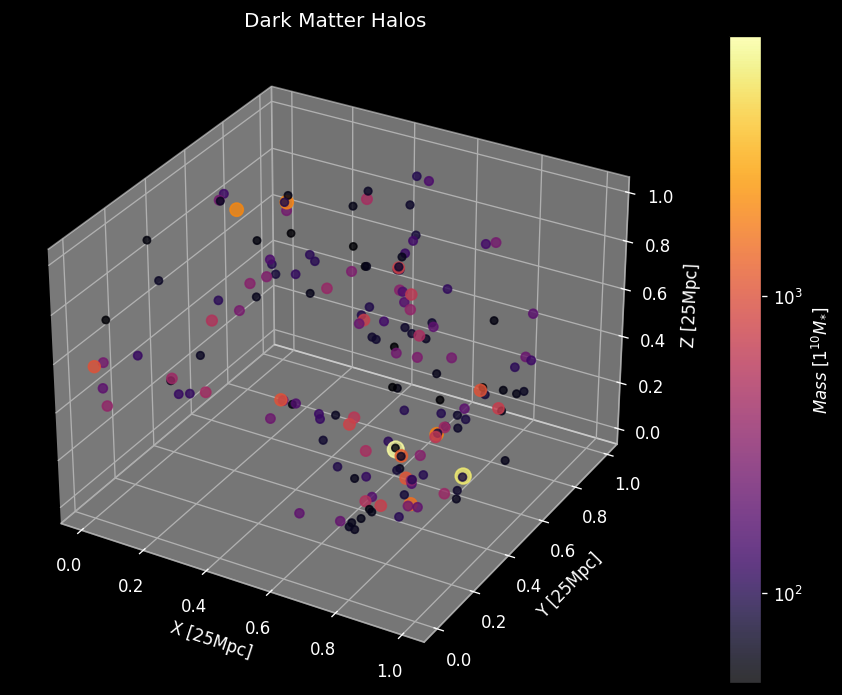

In [6]:
fig = plt.figure(figsize=(15, 7),dpi=120)
ax = fig.add_subplot(111, projection='3d', facecolor='k')
fig.patch.set_facecolor('black')

x,y,z = data['sim_0'][:,0],data['sim_0'][:,1], data['sim_0'][:,2] #x,y,z,m
mass = data['sim_0'][:,3]
sc = ax.scatter(x, y, z, c=mass, cmap='inferno', s=5*np.power(mass,1/3), alpha=0.8,norm='log')


cb = plt.colorbar(sc, label=r'$Mass\ [1^{10} M_{*}]$')
cb.ax.yaxis.set_tick_params(color='white')
cb.ax.yaxis.label.set_color('white')


for label in cb.ax.get_yticklabels():
    label.set_color('white')

ax.set_xlabel('X [25Mpc]')
ax.set_ylabel('Y [25Mpc]')
ax.set_zlabel('Z [25Mpc]')
ax.set_title('Dark Matter Halos')
ax.patch.set_facecolor('black')
ax.xaxis.line.set_color((0.7, 0.7, 0.7, 0.7))
ax.yaxis.line.set_color((0.7, 0.7, 0.7, 0.7))
ax.zaxis.line.set_color((0.7, 0.7, 0.7, 0.7))
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.zaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.tick_params(axis='z', colors='white')
ax.title.set_color('white')

plt.show()

Now we are going to construct a suitable data representation. PyTorch Geometric provides the nice Data object to represent a graph

In [7]:
#import os
#import torch

# Install required packages.
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

#!pip install -q torch-scatter -f https://data.pyg.org/wfacetedhl/torch-${TORCH}.html
#!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
#!pip install -q pytorch-lightning

2.1.0+cu121


In [8]:
from torch_geometric.data import Data
import torch
# Our Data object will have two attributes - x - mass, and pos - position.
halos = Data(pos=torch.tensor(data['sim_0'][:,:3],dtype=torch.float32),x=torch.tensor(data['sim_0'][:,3:4],dtype=torch.float32))

Now it's not really a graph yet (or to be precise, it is, but fully disconnected one). So we need to provide it with edges.
We are going to connect all the points that are closer to each other than a certain radius R. This value is going to be a hyperparameter of our network

In [9]:
from torch_cluster import radius_graph
edge_index = radius_graph(halos.pos, r=0.2, loop=False) # r=0.2 corresponf to a radius of 5. Mpc, no self-connections
halos.edge_index = edge_index

In [10]:
edge_index # size [2,N_e] #connect 4 with 0 etc

tensor([[  4,   8,  11,  ...,  67,  26,  34],
        [  0,   0,   0,  ..., 160, 160, 160]])

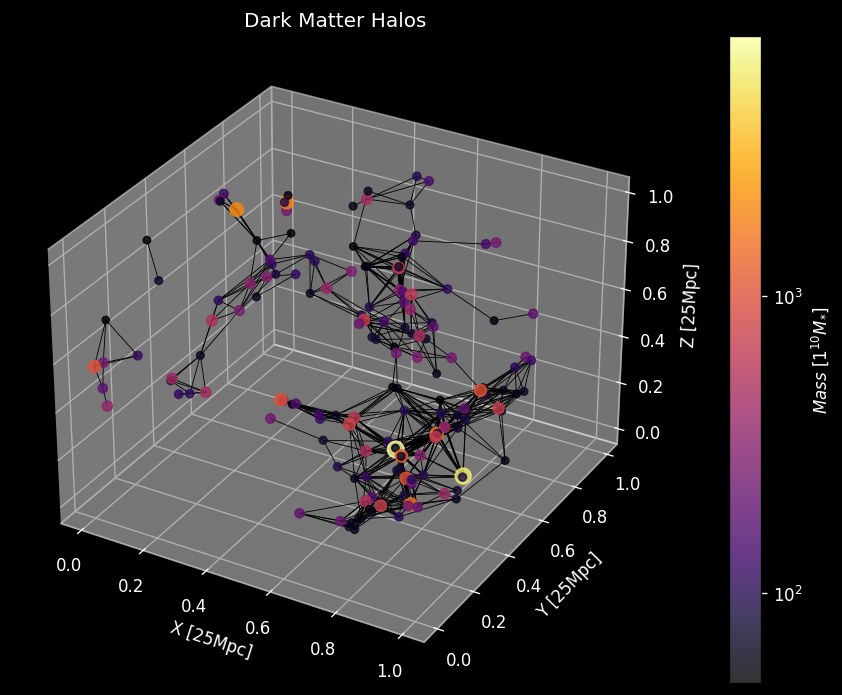

In [11]:
unique_edges = set(tuple(sorted([i.item(), j.item()])) for i, j in edge_index.t())

fig = plt.figure(figsize=(15, 7),dpi=120)
ax = fig.add_subplot(111, projection='3d', facecolor='k')
fig.patch.set_facecolor('black')

z,x,y = (halos.pos[:,i] for i in range(3))
mass = halos.x[:,0]
sc = ax.scatter(z, x, y, c=mass, cmap='inferno', s=5*np.power(mass,1/3), alpha=0.8,norm='log')


cb = plt.colorbar(sc, label=r'$Mass\ [1^{10} M_{*}]$')
cb.ax.yaxis.set_tick_params(color='white')
cb.ax.yaxis.label.set_color('white')


for label in cb.ax.get_yticklabels():
    label.set_color('white')

for start, end in unique_edges:
    ax.plot([z[start], z[end]], [x[start], x[end]], [y[start], y[end]], color='black', linewidth=0.5)

ax.set_xlabel('X [25Mpc]')
ax.set_ylabel('Y [25Mpc]')
ax.set_zlabel('Z [25Mpc]')
ax.set_title('Dark Matter Halos')
ax.patch.set_facecolor('black')
ax.xaxis.line.set_color((0.7, 0.7, 0.7, 0.7))
ax.yaxis.line.set_color((0.7, 0.7, 0.7, 0.7))
ax.zaxis.line.set_color((0.7, 0.7, 0.7, 0.7))
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.zaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.tick_params(axis='z', colors='white')
ax.title.set_color('white')

plt.show()

A graph dataset and dataloader object for convenience

In [12]:
from torch_geometric.data import Dataset
from dataclasses import dataclass
from typing import Callable, Optional, List

@dataclass
class HaloDataset(Dataset):
    graphs_path: str
    labels_path: str
    transform: Optional[Callable] = None
    pre_transform: Optional[Callable] = None


    def __post_init__(self):
        super(HaloDataset, self).__init__("", self.transform, self.pre_transform)
        self.graphs = self.load_graphs(self.graphs_path,
                                       self.labels_path)

    def len(self):
        return len(self.graphs)

    def get(self, idx: int):
        data = self.graphs[idx]
        return data

    @staticmethod #we read one file with ~1000 sims with each ~100 halos
    def load_graphs(graphs_path: str,labels_path: str) -> List[Data]:
        data = np.load(graphs_path) #halos are being read in. not yet graphs.
        values = np.load(labels_path)

        graphs = []
        for n in range(len(data.keys())):
            key = f'sim_{n}'
            halo = Data(pos=torch.tensor(data[key][:,:3],dtype=torch.float32),
                        x=torch.tensor(data[key][:,3:4],dtype=torch.float32),
                        y=torch.tensor(values[n],dtype=torch.float32).view(1,1)) # the value we want to predict
            graphs.append(halo)
        return graphs

halodata = HaloDataset(path+'/halos.npz',path+'/si8_values.npy')

First we are going to write an embedding layer (i.e. an initial layer that would do some precomputing, like calculation of an edge_index given some r_link and edge features)

For now, we are going to use relative distances as edge features

In [13]:
from torch_geometric.nn import MetaLayer
from torch.nn import Sequential, Linear, ReLU, ModuleList, LayerNorm, Dropout

#this computes latent representations for the edge and node features. could be part of the main model also.
#it also creates the edges, and giving them the value of the distance
#this will initialize the features on the nodes and edges.
class GraphEmbeddingModel(torch.nn.Module):
    def __init__(self, r_link, node_emb_size, edge_emb_size, hidden_size):
        super().__init__()
        self.r_link = r_link
        self.node_embedding = Sequential(Linear(1,hidden_size),
                                          ReLU(),
                                          Linear(hidden_size,node_emb_size))
        self.edge_embedding = Sequential(Linear(3,hidden_size),
                                          ReLU(),
                                          Linear(hidden_size,edge_emb_size))
                                          #3 distances: dx,dy,dz

    def forward(self, data):
        x = data.x
        pos = data.pos
        batch = data.batch

        edge_index = radius_graph(pos, r = self.r_link, batch=batch, loop = False)

        senders = edge_index[0]
        receivers = edge_index[1]

        r_ij = pos[senders] - pos[receivers]

        edge_attr = r_ij

        edge_attr = self.edge_embedding(r_ij)
        x = self.node_embedding(x)

        return x, edge_index, edge_attr, batch

Now we need to implement all the other components.

In [14]:
from torch_scatter import scatter_mean, scatter_sum, scatter_max, scatter_min, scatter_add
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool

class EdgeModel(torch.nn.Module):
    def __init__(self,node_in, edge_in, hidden_size, edge_out):
        super().__init__()
        self.edge_mlp = Sequential(Linear(edge_in + 2*node_in, hidden_size),
                                    ReLU(),
                                    #Dropout(0.3),
                                    Linear(hidden_size, edge_out),
                                  )

    def forward(self, src, dst, edge_attr, u, batch):
        # src, dst: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.
        out = torch.cat([src, dst, edge_attr], 1)
        return self.edge_mlp(out)

class NodeModel(torch.nn.Module):
    def __init__(self, node_in, edge_in, hidden_size, node_out):
        super().__init__()

        #the 3 is from 3 aggregations, not 3 dimensions.
        layers = [Linear(node_in + 3*edge_in, hidden_size),
                  ReLU(),
                  #Dropout(0.3),
                  Linear(hidden_size, node_out),
                  LayerNorm(node_out),
                 ]

        self.node_mlp = Sequential(*layers)

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.

        row, col = edge_index
        out = edge_attr

        # Multipooling layer
        out1 = scatter_add(out, col, dim=0, dim_size=x.size(0))
        out2 = scatter_max(out, col, dim=0, dim_size=x.size(0))[0]
        out3 = scatter_mean(out, col, dim=0, dim_size=x.size(0))
        #addition, max and mean for aggregation. we do all 3 and concatenate. then we pass them through MLP.

        to_concat = [out1,out2,out3, x]

        out = torch.cat(to_concat, dim=1)
        out = self.node_mlp(out)
        return out

class GlobalModel(torch.nn.Module):
    def __init__(self, node_in, hidden_size, global_out):
        super().__init__()

        layers = [Linear(3*node_in, hidden_size),
                  ReLU(),
                  #Dropout(0.3),
                  Linear(hidden_size, global_out)]

        self.mlp = Sequential(*layers)


    def forward(self, x, edge_index, edge_attr, u, batch):

        addpool = global_add_pool(x, batch)
        meanpool = global_mean_pool(x, batch)
        maxpool = global_max_pool(x, batch)
        #3 ways for global pooling

        to_cat = [addpool,meanpool,maxpool]

        out = torch.cat(to_cat, dim=1)
        out = self.mlp(out)
        return out
        #output is 1 number.

class GraphLayer(torch.nn.Module):
    def __init__(self, node_in, edge_in, hidden_size, node_out, edge_out):
        super().__init__()
        self.layer = MetaLayer(edge_model=EdgeModel(node_in = node_in, edge_in = edge_in, hidden_size = hidden_size, edge_out = edge_out),
                               node_model=NodeModel(node_in = node_in, edge_in = edge_out, hidden_size = hidden_size, node_out = node_out))

    def forward(self, x, edge_index, edge_attr, batch):
        return self.layer(x, edge_index, edge_attr, batch=batch)


class MPGNN(torch.nn.Module):
    def __init__(self, r_link, node_emb_size, edge_emb_size, hidden_size, n_layers, global_out):
        super().__init__()
        self.embedding = GraphEmbeddingModel(r_link, node_emb_size, edge_emb_size, hidden_size)

        layers = []

        edge_in, node_in = (edge_emb_size, node_emb_size)
        edge_out, node_out = (hidden_size, hidden_size)

        for i in range(n_layers):

            layers.append(GraphLayer(node_in, edge_in, hidden_size, node_out, edge_out))
            node_in = node_out; edge_in = edge_out

        layers.append(MetaLayer(global_model=GlobalModel(node_in = node_in, hidden_size = hidden_size, global_out = global_out)))
        #we have N layers of graph layers, and one global layer. here we do not perform many g updates.

        self.layers = ModuleList(layers)



    def forward(self, data):
        x, edge_index, edge_attr, batch = self.embedding(data)

        for layer in self.layers:
            x, edge_attr, u = layer(x, edge_index, edge_attr, batch = batch)
        return u

### Learning to predict target value and uncertainty
In physics (not only in physics), the point estimate without the uncertainty is meaningless. So we are going to make our neural net to learn the uncertainty as well. This type of tasks is called
heteroscedastic regression. One way to achieve this is to modify the assumption that the residuals are normally distributed with zero mean and fixed variance (common underlying assumption that results in MSE loss) to the one that doesn't assume the same variance for each term. That results in adding an MSE term but for variance itself.

In [15]:
def heterosc_loss(mean, std, true):
    return torch.log(torch.mean((mean-true) ** 2)) + torch.log(torch.mean(((mean-true) ** 2 - std ** 2) ** 2))
    #this loss can also be used to learn the mean and variance. it is not the same as the one we discussed in the lecture.

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pytorch_lightning as pl

class MPGNNLighnting(pl.LightningModule):
    def __init__(self, r_link, node_emb_size, edge_emb_size, hidden_size, n_layers, global_out, lr=5e-4, wd=8e-3):
        super().__init__()
        self.r_link = r_link
        self.node_emb_size = node_emb_size
        self.edge_emb_size = edge_emb_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.global_out = global_out
        self.lr = lr
        self.wd = wd
        self.model = MPGNN(self.r_link, self.node_emb_size, self.edge_emb_size, self.hidden_size, self.n_layers, self.global_out)
        self.save_hyperparameters()


    def forward(self, inp):
        otp = self.model(inp)
        mean = otp[:,0:1]
        std = otp[:, 1:2]
        return mean, std

    def training_step(self, batch, batch_idx): # this is different from batch vector above.
        mean, std = self(batch)
        true = batch.y
        loss = heterosc_loss(mean,std,true)
        batch_size = batch.num_graphs
        self.log('train_loss', loss, on_step=True, on_epoch=True, batch_size=batch_size)

        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        mean, std = self(batch)
        true = batch.y
        loss = heterosc_loss(mean,std,true)
        batch_size = batch.num_graphs
        self.log('val_loss', loss, on_step=True, on_epoch=True, batch_size=batch_size)
        return {'val_loss': loss}


    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return torch.cat([*self(batch), batch.y], dim=1)


    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(),lr=self.lr,weight_decay=self.wd)
        return [optimizer]

In [16]:
torch.set_float32_matmul_precision('medium')

In [17]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(halodata.graphs[:1100],shuffle=True,batch_size=20,num_workers=6,persistent_workers=True)
valid_loader = DataLoader(halodata.graphs[1100:],shuffle=False,batch_size=20,num_workers=6,persistent_workers=True)

tensorboard_logger = TensorBoardLogger(path+'/tb_logs')

# we are going to use early stopping to prevent overfitting. we save only the model that results in lower validation loss
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath=path+'/', filename=f"my_mpgnn", save_top_k=1, mode='min')


trainer = Trainer(max_epochs=200, accelerator='gpu', devices=[0], callbacks=[checkpoint_callback], logger=tensorboard_logger,check_val_every_n_epoch=5,log_every_n_steps=5)

model = MPGNNLighnting(r_link=0.2, node_emb_size=8, edge_emb_size=8, hidden_size=32, n_layers=2, global_out=2)
trainer.fit(model, train_loader, valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\odog2\.conda\envs\Python310\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\odog2\OneDrive\Desktop\04_Problem_Set exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params | Mode 
----------------------------------------
0 | model | MPGNN | 19.6 K | train
----------------------------------------
19.6 K    Trainable params
0         Non-trainable params
19.6 K    Total params
0.079     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 55/55 [00:01<00:00, 44.97it/s, v_num=10]         
idation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 55/55 [00:01<00:00, 39.48it/s, v_num=10]      
idation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 55/55 [00:01<00:00, 35.23it/s, v_num=10]     
idation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 55/55 [00:01<00:00, 39.06it/s, v_num=10]     
idation: |          | 0/? [00:00<?, ?it/s]
Epoch 24: 100%|██████████| 55/55 [00:01<00:00, 37.27it/s, v_num=10]     
idation: |          | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|██████████| 55/55 [00:01<00:00, 39.11it/s, v_num=10]     
idation: |          | 0/? [00:00<?, ?it/s]
Epoch 34: 100%|██████████| 55/55 [00:01<00:00, 39.63it/s, v_num=10]     
idation: |          | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████| 55/55 [00:01<00:00, 39.12it/s, v_num=10]     
idation: |          | 0/? [00:00<?, ?it/s]
Epoch 44: 100%|██████████| 55/55 [00:01<00:00, 38.75it/s, v_num=10]  

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 55/55 [00:01<00:00, 34.13it/s, v_num=10]


In [18]:
from torch_geometric.loader import DataLoader
model = MPGNNLighnting.load_from_checkpoint(path +'/my_mpgnn.ckpt',gnn=MPGNN(r_link=0.2, node_emb_size=16, edge_emb_size=16, hidden_size=48, n_layers=2, global_out=2))
trainer = pl.Trainer(accelerator='gpu', devices=[0], logger=False)
def get_predictions(trainer,model,dataloader):
    preds = torch.cat(trainer.predict(model,dataloaders=dataloader),dim=0).numpy()
    return preds[:, 0] ,preds[:, 1], preds[:, 2]
test_loader = DataLoader(halodata.graphs[1300:],shuffle=False,batch_size=10, num_workers=6)
predictions,errors,true_values = get_predictions(trainer,model,test_loader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\odog2\.conda\envs\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 10.55it/s]


In [19]:
def get_stats(predictions,std_devs,true_values):
    eps = np.mean(np.abs(predictions-true_values)/predictions,axis=0)
    r2 = 1-np.sum((predictions-true_values)**2,axis=0)/np.sum((true_values-np.mean(true_values,axis=0))**2,axis=0)
    chi2 = np.mean((predictions-true_values)**2/std_devs**2,axis=0)
    return np.round(100*eps,3), np.round(r2,3), np.round(chi2,3)


def plot_results_1var(predictions, std_devs, true_values):
    # Create the plot
    f, axs = plt.subplots(1, 1, figsize=(6, 6))

    eps,r2,chi2 = get_stats(predictions,std_devs,true_values)

    # Data for text box (example)
    textstr = '$\epsilon$: {}$\%$\n$r^2$: {}\n$\chi^2$: {}'.format(eps, r2,chi2)


    # Setting for the text box
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # Plotting for the first subplot
    axs.errorbar(true_values, predictions, yerr=std_devs, fmt='o', label='Predictions', alpha=0.6)
    axs.plot([np.min(true_values), np.max(true_values)], [np.min(true_values), np.max(true_values)], 'r--', label='$y=x_{true}$')
    axs.set_xlabel('True Values')
    axs.set_ylabel('Predictions')
    axs.set_title('$\sigma_8$', fontsize=20)
    axs.set_xlim(0.58,1.02)
    axs.set_ylim(0.58,1.02)
    axs.legend(fontsize=16)
    axs.grid(True)

    # Adding text box to the first subplot
    axs.text(0.95, 0.05, textstr, transform=axs.transAxes, fontsize=14,
                verticalalignment='bottom', horizontalalignment='right', bbox=props)
    plt.show()

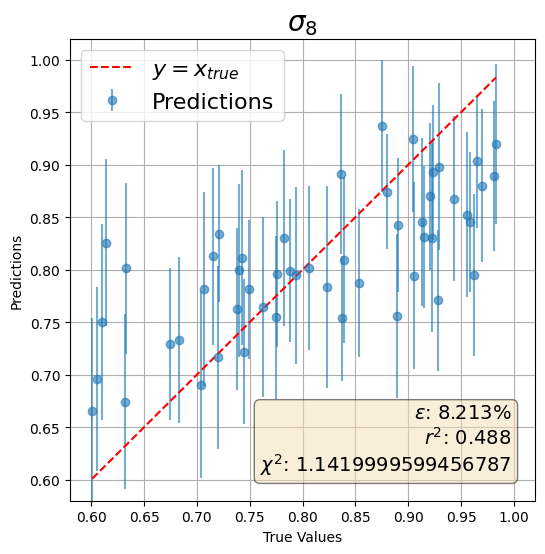

In [20]:
plot_results_1var(predictions,np.abs(errors),true_values)

## What about symmetries?
The neural net we used so far takes directly differences of positions as inputs, meanwhile, the parameter we are trying to estimate is agnostic to the orientation of the halo cloud in the volume.
One way to incorporate this knowledge is to make features we use manifestly rotationally and translationally invariant. (see https://arxiv.org/abs/2204.13713 for more details).
Instead of $\mathbf{r_{ij}} = \mathbf{x_i} - \mathbf{x_j}$, construct the new edge feature vector. Let's define $d_{ij} = |r_{ij}|$, $\mathbf{n_{ij}} = \mathbf{r_{ij}}/d_{ij}$,
$\mathbf{p}_i = (\mathbf{x_i}-\mathbf{\bar{x}}) / |(\mathbf{x_i}-\mathbf{\bar{x}})|$, where $\mathbf{\bar{x}}$ is some constant vector (one can take the center of mass). Then, we can form a new features:
($d_{ij}$, $\mathbf{p}_i \cdot \mathbf{p}_j$, $\mathbf{p}_i \cdot  \mathbf{n_{ij}}$) that are going to be rotationally and translationally invariant.
### Task 1. Implement this by making appropriate modifications to the GraphEmbeddingModel. Train the resulting model and compare the results.


In [22]:
class GraphEmbeddingModel(torch.nn.Module):
    def __init__(self, r_link, node_emb_size, edge_emb_size, hidden_size):
        super().__init__()
        self.r_link = r_link
        self.node_embedding = Sequential(Linear(1,hidden_size),
                                          ReLU(),
                                          Linear(hidden_size,node_emb_size))
        self.edge_embedding = Sequential(Linear(3,hidden_size),
                                          ReLU(),
                                          Linear(hidden_size,edge_emb_size))
                                          #3 distances: dx,dy,dz

    def forward(self, data):
        x = data.x
        pos = data.pos
        batch = data.batch

        edge_index = radius_graph(pos, r = self.r_link, batch=batch, loop = False)

        senders = edge_index[0]
        receivers = edge_index[1]

        r_ij = pos[senders] - pos[receivers]

        
        # ----------New Addition----------
        d_ij = torch.norm(r_ij, dim=1, keepdim=True)
        n_ij = r_ij / (d_ij + 1e-8)

        batch_size = batch.max().item() + 1
        cm = torch.zeros((batch_size, pos.shape[1]), device=pos.device)
        for i in range(batch_size):
            mask = batch == i
            cm[i] = pos[mask].mean(dim=0)

        p_i = (pos - cm[batch]) / (torch.norm(pos - cm[batch], dim=1, keepdim=True) + 1e-8)

        p_i_dot_p_j = (p_i[senders] * p_i[receivers]).sum(dim=1, keepdim=True)
        p_i_dot_n_ij = (p_i[senders] * n_ij).sum(dim=1, keepdim=True)

        edge_attr = self.edge_embedding(torch.cat([d_ij, p_i_dot_p_j, p_i_dot_n_ij], dim=1))
        # ----------New Addition----------

        
        x = self.node_embedding(x)

        return x, edge_index, edge_attr, batch

In [23]:
train_loader = DataLoader(halodata.graphs[:1100],shuffle=True,batch_size=20,num_workers=6,persistent_workers=True)
valid_loader = DataLoader(halodata.graphs[1100:],shuffle=False,batch_size=20,num_workers=6,persistent_workers=True)
tensorboard_logger = TensorBoardLogger(path+'/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath=path+'/', filename=f"my_mpgnn", save_top_k=1, mode='min')
trainer = Trainer(max_epochs=200, accelerator='gpu', devices=[0], callbacks=[checkpoint_callback], logger=tensorboard_logger,check_val_every_n_epoch=5,log_every_n_steps=5)
model = MPGNNLighnting(r_link=0.2, node_emb_size=8, edge_emb_size=8, hidden_size=32, n_layers=2, global_out=2)
trainer.fit(model, train_loader, valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params | Mode 
----------------------------------------
0 | model | MPGNN | 19.6 K | train
----------------------------------------
19.6 K    Trainable params
0         Non-trainable params
19.6 K    Total params
0.079     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 55/55 [00:01<00:00, 30.79it/s, v_num=11]         
idation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 55/55 [00:01<00:00, 28.65it/s, v_num=11]      
idation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 55/55 [00:01<00:00, 30.74it/s, v_num=11]     
idation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 55/55 [00:01<00:00, 30.46it/s, v_num=11]     
idation: |          | 0/? [00:00<?, ?it/s]
Epoch 24: 100%|██████████| 55/55 [00:01<00:00, 30.71it/s, v_num=11]     
idation: |          | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|██████████| 55/55 [00:01<00:00, 31.44it/s, v_num=11]     
idation: |          | 0/? [00:00<?, ?it/s]
Epoch 34: 100%|██████████| 55/55 [00:01<00:00, 30.29it/s, v_num=11]     
idation: |          | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████| 55/55 [00:01<00:00, 31.68it/s, v_num=11]     
idation: |          | 0/? [00:00<?, ?it/s]
Epoch 44: 100%|██████████| 55/55 [00:01<00:00, 29.25it/s, v_num=11]  

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 55/55 [00:02<00:00, 24.46it/s, v_num=11]


In [24]:
model = MPGNNLighnting.load_from_checkpoint(path +'/my_mpgnn.ckpt',gnn=MPGNN(r_link=0.2, node_emb_size=16, edge_emb_size=16, hidden_size=48, n_layers=2, global_out=2))
trainer = pl.Trainer(accelerator='gpu', devices=[0], logger=False)
def get_predictions(trainer,model,dataloader):
    preds = torch.cat(trainer.predict(model,dataloaders=dataloader),dim=0).numpy()
    return preds[:, 0] ,preds[:, 1], preds[:, 2]
test_loader = DataLoader(halodata.graphs[1300:],shuffle=False,batch_size=10, num_workers=6)
predictions,errors,true_values = get_predictions(trainer,model,test_loader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 10.29it/s]


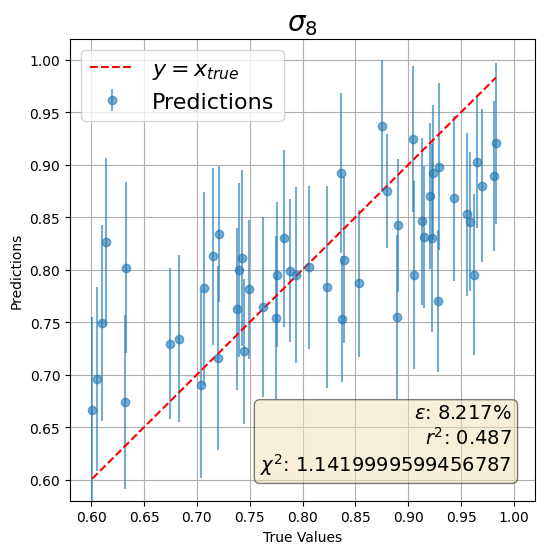

In [25]:
plot_results_1var(predictions,np.abs(errors),true_values)

### Task 2. (Optional) Can you come up with a model that would give smaller $\epsilon$ ?
This is an open-ended task. I encourage you to go to https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers and try some other things instead of
the Message Passing GNN that was presented here. See if you can get smaller $\epsilon$